This is some interesting maths...

$\sum{}_{i=1}^{n} i = \frac{n(n+1)}{2}$

In [1]:
#imports
# %matplotlib widget
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display_markdown
import datetime
from datetime import datetime as dt
from numpy import nan

from import_OMNI import read_OMNI, nan_value
from import_ACE import read_ACE
from import_cdaweb import read_CDAWeb
from entropy import H, MI, CMI, entropy_matrix
from storm_selection import findSeq
from import_RTSW import read_RTSW_ACE


In [2]:
# storm = read_OMNI(
#     filepath="../OMNI/datasets/test_2.txt",
#     formatpath="../OMNI/data_format/test_2_format.txt",
# )
# # for column in list(df)[1:]:
#     # plt.plot(df["Datetime"], df[column], label=column)
# plt.plot(df["Datetime"], df["BZ"], label="BZ")
# # plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# # plt.hist(storm["SYM/H"], 150)
# plt.legend()
# plt.show()

In [3]:
def markdown_entropy_matrix(df, bins=200, ignore_columns=[0], use_scipy=False, knn=False):
    em = entropy_matrix(df, bins=bins, ignore_columns=ignore_columns, use_scipy=use_scipy, knn=knn)

    display_markdown(
f'''| |{"|".join(df.columns[1:])}|
{"".join(["|:-"] * len(df.columns))}|
{"\n".join([f"|{column_name}|{"|".join(map(lambda x: "%.2f" % x, em[i]))}|" for i, column_name in enumerate(df.columns[1:])])}
|Number of datapoints|{"|".join([str(len(df[column])) for column in df.columns[1:]])}|
''',
    raw = True
    )

In [4]:
# markdown_entropy_matrix(df)

c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


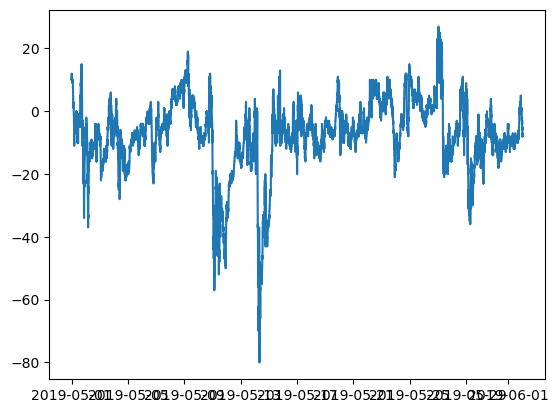

In [5]:
df = read_OMNI(
    filepath="../OMNI/datasets/2019_March_data.txt",
    formatpath="../OMNI/data_format/2019_March_data_format.txt",
)
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.show()

In [6]:
lower_thresh, upper_thresh = 20, 50
inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)
# plt.plot(df["Datetime"], df["SYM/H, nT"])

Min / max thresholds are: 20.00 , 50.00
3 sequences found.
Joining two sequences next to each other (within the threshold).


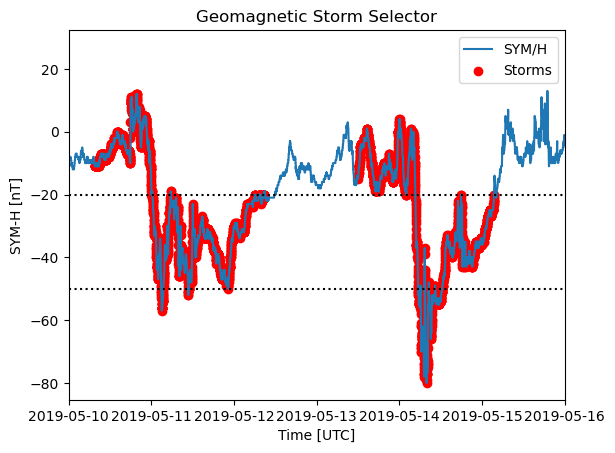

In [7]:
plt.figure()
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.scatter(df["Datetime"].iloc[inds],df["SYM/H"].iloc[inds],color='r',label='Storms')
plt.axhline(-lower_thresh,color='k',linestyle=':')
plt.axhline(-upper_thresh,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')
plt.xlim(datetime.datetime(2019, 5, 10), datetime.datetime(2019, 5, 16))
plt.legend()
plt.show()

In [8]:
storm_entropies = [H(df["SYM/H"].iloc[range(storm[0], storm[1])]) for storm in ranges]

print(f"Nominal SYM/H entropy: {H(df["SYM/H"])}")
print(f"Storm SYM/H entropies: {storm_entropies} \nAverage storm entropy (per storm): {sum(storm_entropies)/len(storm_entropies)}")
print(f"Storm entropies calculated taking storms as a set of datapoints: {H(df["SYM/H"].iloc[inds])}")
# we can initially discern a large increase in information describing SYM/H
print("Entropy Matrix for storms:")
markdown_entropy_matrix(df.iloc[inds])
print("Entropy Matrix for all data:")
markdown_entropy_matrix(df)

Nominal SYM/H entropy: 5.3815728793369155
Storm SYM/H entropies: [5.5921725345894595, 5.818315309802384] 
Average storm entropy (per storm): 5.705243922195922
Storm entropies calculated taking storms as a set of datapoints: 5.987156034385624
Entropy Matrix for storms:


| |AE-index|AL-index|AU-index|SYM/D|SYM/H|ASY/D|ASY/H|
|:-|:-|:-|:-|:-|:-|:-|:-|
|AE-index|6.53|3.00|2.49|0.99|1.91|1.67|1.86|
|AL-index|3.00|6.09|1.97|0.88|1.74|1.49|1.67|
|AU-index|2.49|1.97|6.49|0.89|1.72|1.47|1.72|
|SYM/D|0.99|0.88|0.89|3.96|1.16|1.00|1.08|
|SYM/H|1.91|1.74|1.72|1.16|5.99|1.66|1.85|
|ASY/D|1.67|1.49|1.47|1.00|1.66|5.75|1.67|
|ASY/H|1.86|1.67|1.72|1.08|1.85|1.67|6.02|
|Number of datapoints|5318|5318|5318|5318|5318|5318|5318|


Entropy Matrix for all data:


| |AE-index|AL-index|AU-index|SYM/D|SYM/H|ASY/D|ASY/H|
|:-|:-|:-|:-|:-|:-|:-|:-|
|AE-index|5.14|1.83|1.43|0.24|0.47|0.39|0.54|
|AL-index|1.83|4.58|0.78|0.21|0.43|0.35|0.48|
|AU-index|1.43|0.78|5.46|0.22|0.47|0.35|0.50|
|SYM/D|0.24|0.21|0.22|3.27|0.24|0.22|0.21|
|SYM/H|0.47|0.43|0.47|0.24|5.38|0.40|0.52|
|ASY/D|0.39|0.35|0.35|0.22|0.40|5.18|0.38|
|ASY/H|0.54|0.48|0.50|0.21|0.52|0.38|5.11|
|Number of datapoints|46080|46080|46080|46080|46080|46080|46080|


In [9]:
# evaluating average entropies of all stats in a storm
stormy_H = np.array([H(df[column].iloc[inds]) for column in list(df)[1:]])

nominal_H =  np.array([H(df[column]) for column in list(df)[1:]])

stormy_H - nominal_H

array([1.38648473, 1.50780848, 1.03185059, 0.69040972, 0.60558316,
       0.57245759, 0.91549906])

In [10]:
def find_bin_num(func, default = 100):
    bin_num = default
    while not np.isclose(func(bin_num), func(bin_num-50)):
        bin_num += 100
    return bin_num


In [11]:
def gradient_desc(f, initial = 100, step_size = 100, weight = 1):
    x = initial
    grad = f(x+step_size) - f(x)
    while not np.isclose(grad,0):
        print(x, grad)
        x += int(grad*step_size*weight)
        grad = f(x+step_size) - f(x)
        
    return x+step_size

In [12]:
# [find_bin_num(lambda x: H(df[column], bins=x)) for column in list(df)[1:]]

In [13]:
df2 = read_ACE("../ACE/ACE_Browse_Data.txt")
df2.columns.difference(["ACE_epoch_time"], sort=False), MI(df2[df2.columns.difference(["ACE_epoch_time"], sort=False)], df2["B_rtn_t_MAG"], knn=True)

(Index(['B_rtn_r_MAG', 'B_rtn_t_MAG', 'B_rtn_n_MAG', 'B_rtn_theta_MAG',
        'B_rtn_phi_MAG', 'B_gse_x_MAG', 'B_gse_y_MAG', 'B_gse_z_MAG',
        'B_gse_theta_MAG', 'B_gse_phi_MAG', 'B_gsm_x_MAG', 'B_gsm_y_MAG',
        'B_gsm_z_MAG', 'B_gsm_theta_MAG', 'B_gsm_phi_MAG', 'B_magnitude_MAG'],
       dtype='object'),
 array([ 0.1360446 , 10.17832741,  0.06040979,  0.09186874,  1.34624455,
         0.13646843,  2.80175566,  0.05910385,  0.07687664,  1.21985253,
         0.13647005,  1.47115123,  0.06515376,  0.04103381,  0.89138838,
         0.49299849]))

In [14]:
markdown_entropy_matrix(df2, knn=True)

| |B_rtn_r_MAG|B_rtn_t_MAG|B_rtn_n_MAG|B_rtn_theta_MAG|B_rtn_phi_MAG|B_gse_x_MAG|B_gse_y_MAG|B_gse_z_MAG|B_gse_theta_MAG|B_gse_phi_MAG|B_gsm_x_MAG|B_gsm_y_MAG|B_gsm_z_MAG|B_gsm_theta_MAG|B_gsm_phi_MAG|B_magnitude_MAG|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|B_rtn_r_MAG|10.16|0.14|0.04|0.09|1.24|6.46|0.13|0.04|0.09|1.23|6.46|0.13|0.04|0.10|1.22|0.30|
|B_rtn_t_MAG|0.14|10.18|0.06|0.09|1.35|0.14|2.80|0.06|0.08|1.22|0.14|1.47|0.07|0.04|0.89|0.49|
|B_rtn_n_MAG|0.04|0.06|10.14|1.67|0.04|0.04|0.05|2.28|1.33|0.03|0.04|0.06|1.01|0.74|0.04|0.30|
|B_rtn_theta_MAG|0.09|0.09|1.67|10.29|0.02|0.09|0.09|1.34|2.31|0.01|0.09|0.05|0.73|0.92|0.03|0.03|
|B_rtn_phi_MAG|1.24|1.35|0.04|0.02|10.30|1.24|1.21|0.04|0.02|3.77|1.24|0.89|0.04|0.04|2.43|0.07|
|B_gse_x_MAG|6.46|0.14|0.04|0.09|1.24|10.16|0.13|0.04|0.09|1.24|10.16|0.13|0.04|0.10|1.23|0.30|
|B_gse_y_MAG|0.13|2.80|0.05|0.09|1.21|0.13|10.18|0.06|0.09|1.35|0.13|1.55|0.06|0.04|0.92|0.49|
|B_gse_z_MAG|0.04|0.06|2.28|1.34|0.04|0.04|0.06|10.14|1.67|0.04|0.04|0.06|1.10|0.79|0.04|0.30|
|B_gse_theta_MAG|0.09|0.08|1.33|2.31|0.02|0.09|0.09|1.67|10.29|0.02|0.09|0.05|0.78|1.02|0.03|0.03|
|B_gse_phi_MAG|1.23|1.22|0.03|0.01|3.77|1.24|1.35|0.04|0.02|10.30|1.24|0.92|0.04|0.03|2.53|0.07|
|B_gsm_x_MAG|6.46|0.14|0.04|0.09|1.24|10.16|0.13|0.04|0.09|1.24|10.16|0.13|0.04|0.10|1.23|0.30|
|B_gsm_y_MAG|0.13|1.47|0.06|0.05|0.89|0.13|1.55|0.06|0.05|0.92|0.13|10.18|0.04|0.09|1.35|0.46|
|B_gsm_z_MAG|0.04|0.07|1.01|0.73|0.04|0.04|0.06|1.10|0.78|0.04|0.04|0.04|10.14|1.65|0.04|0.31|
|B_gsm_theta_MAG|0.10|0.04|0.74|0.92|0.04|0.10|0.04|0.79|1.02|0.03|0.10|0.09|1.65|10.29|0.02|0.03|
|B_gsm_phi_MAG|1.22|0.89|0.04|0.03|2.43|1.23|0.92|0.04|0.03|2.53|1.23|1.35|0.04|0.02|10.30|0.07|
|B_magnitude_MAG|0.30|0.49|0.30|0.03|0.07|0.30|0.49|0.30|0.03|0.07|0.30|0.46|0.31|0.03|0.07|10.06|
|Number of datapoints|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|105120|


In [15]:
MI(df2["B_rtn_r_MAG"], df2["B_rtn_r_MAG"], knn=True)

array([10.16038083])

In [16]:
def make_cda_df(mag_path, swepam_path):
    mag, swepam = read_CDAWeb(mag_path=mag_path, swepam_path=swepam_path)
    mag = mag.resample("64s", on="Epoch", label="left").mean().reset_index()
    df = pd.concat([mag, swepam[swepam.columns[1:]]], axis=1)
    df.rename(columns={"Epoch": "Datetime"}, inplace=True)
    return df

In [353]:
def storm_analysis(indicies_data, L1_data, max_time_diff=60, min_time_diff=5):
    """
    Perform storm analysis on the given data.

    Parameters:
    - indicies_data (DataFrame): DataFrame containing ground index data.
    - L1_data (DataFrame): DataFrame containing L1 data.
    - max_time_diff (int, optional): Maximum time difference in minutes. Defaults to 60.
    - min_time_diff (int, optional): Minimum time difference in minutes. Defaults to 5.

    Returns:
    - MI_matrices (ndarray): Array of mutual information matrices.
    - times (ndarray): Array of times of the ends of corresponding convolutions.

    Raises:
    - ValueError: If no valid convolutions are found.
    """

    window_width = len(indicies_data)
    time_to_end = (indicies_data["Datetime"].max() - L1_data["Datetime"]).dt.total_seconds() // 60
    first_index = time_to_end.index[np.searchsorted(time_to_end.index, (time_to_end <= max_time_diff).idxmax()) - window_width]
    L1_data = L1_data[time_to_end >= min_time_diff].loc[first_index:]
    rolling_data = L1_data.rolling(window=window_width)
    to_test = []

    for convolution in rolling_data:
        if convolution.shape[0] != window_width:
            to_test.append(False)
        elif (indicies_data["Datetime"].max() - convolution["Datetime"].max()).total_seconds() // 60 > max_time_diff:
            to_test.append(False)
        else:
            to_test.append(True)
    if sum(to_test) == 0:
        raise ValueError("No valid convolutions found")

    to_test = np.array(to_test)
    num_to_test = to_test.sum()
    MI_matrices = []
    times = []

    conv_data_columns = convolution.columns.difference(["Datetime"], sort=False)
    indicies_data_columns = indicies_data.columns.difference(["Datetime"], sort=False)
    for i, convolution in enumerate(rolling_data):
        if to_test[i]:
            print(f"\r{100 * (len(MI_matrices)) / (num_to_test):.2f}% complete, analysing window starting on {convolution['Datetime'].min()}", end="\r")
            MI_matrix = np.array([MI(convolution[conv_data_columns], indicies_data[col_j], knn=True, n_cores=-2) for col_j in indicies_data_columns])
            MI_matrices.append(MI_matrix)
            times.append(convolution["Datetime"].max())
    MI_matrices = np.array(MI_matrices)
    times = np.array(times)
    print(f"Analysis complete {" "*50}")
    return MI_matrices, times

c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 20.00 , 50.00
3 sequences found.
Joining two sequences next to each other (within the threshold).
175996    True
175997    True
175998    True
175999    True
176000    True
          ... 
201145    True
201146    True
201147    True
201148    True
201149    True
Name: Datetime, Length: 25154, dtype: bool
Analysis complete                                                   


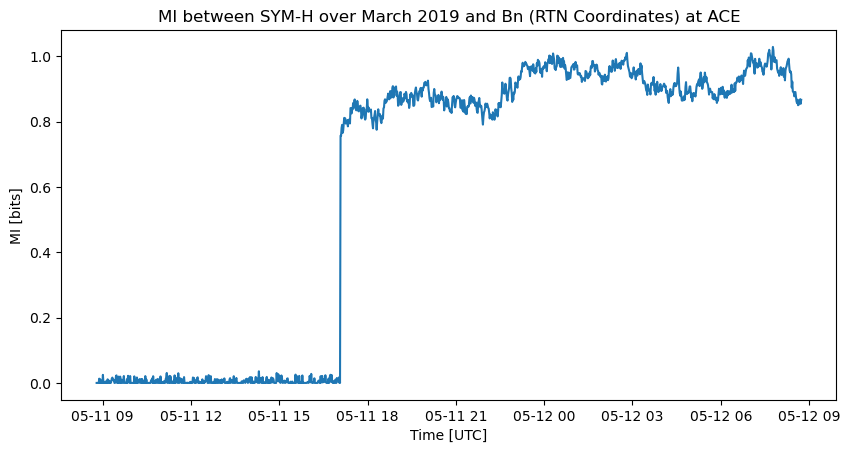

In [247]:
L1_data = make_cda_df("../CDAWeb/ac_h3s_mfi_20190101000000_20190529235959.cdf", "../CDAWeb/ac_h0s_swe_20190101000053_20190529235924.cdf")
df = read_OMNI(
    filepath="../OMNI/datasets/2019_March_data.txt",
    formatpath="../OMNI/data_format/2019_March_data_format.txt",
)
lower_thresh, upper_thresh = 20, 50
inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)

storm_data = [df.iloc[range(storm[0], storm[1])] for storm in ranges]
storm = storm_data[0]

MI_matrices, times = storm_analysis(storm, L1_data, max_time_diff=60*24)
# MI_matrices.shape, L1_data.columns[1:], storm.columns[1:] # just checking everything is working as expected
plt.figure(figsize=[10, 4.8])
plt.plot(times, MI_matrices[:, -3, 2]) # first number indexes the OMNI column, second indexes the ACE column
plt.title('MI between SYM-H over March 2019 and Bn (RTN Coordinates) at ACE')
plt.xlabel('Time [UTC]')
plt.ylabel('MI [bits]')
plt.show() # attempt at plotting MI between Bz and SMH/H

In [ ]:
# np.save("MI matrices.npy", MI_matrices)
max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
max_MI = MI_matrices[max_MI_pos, -3, 2]
times[max_MI_pos], max_MI

c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 20.00 , 45.00
18 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).


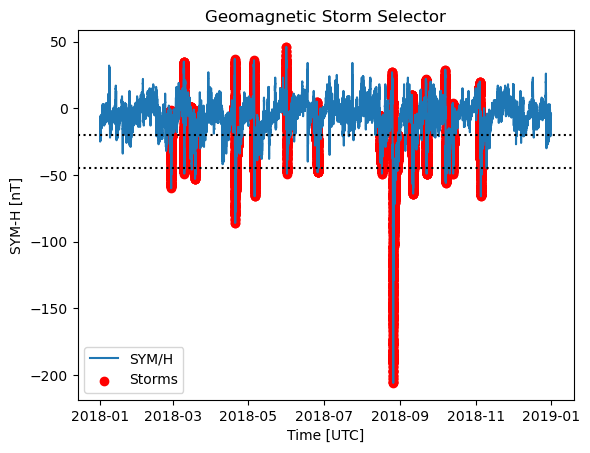

In [257]:
df = read_OMNI(
    filepath="../OMNI/datasets/2018_all.txt",
    formatpath="../OMNI/data_format/2018_all_format.txt",
)
level2 = make_cda_df("../CDAWeb/ac_h0s_mfi_20180101000013_20190101000000.cdf", "../CDAWeb/ac_h0s_swe_20180101000052_20181231235949.cdf")
level1 = read_RTSW_ACE("../172549/realtime_solarwind/ace", 2018)
level1 = level1[level1.columns.difference(["State_x", "State_y"], sort=False)]
lower_thresh, upper_thresh = 20, 45
inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)
storm_data = [df.iloc[range(storm[0], storm[1])] for storm in ranges]
plt.figure()
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.scatter(df["Datetime"].iloc[inds],df["SYM/H"].iloc[inds],color='r',label='Storms')
plt.axhline(-lower_thresh,color='k',linestyle=':')
plt.axhline(-upper_thresh,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')
plt.legend()
plt.show()

In [426]:
max_MI_times2 = []
max_MIs2 = []
all_storm_MI_matrices2 = []
all_matrix_times2 = []
analysed2 = []

for i, storm in enumerate(storm_data):
    print(f"storm {i+1}/{len(storm_data)}")
    try:
        MI_matrices, times = storm_analysis(storm, level2, max_time_diff=60*3)
        max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
        max_MI = MI_matrices[max_MI_pos, -3, 2]
        max_MI_time_delta = times[max_MI_pos] - storm["Datetime"].max()

        max_MI_times2.append(max_MI_time_delta)
        max_MIs2.append(max_MI)
        all_storm_MI_matrices2.append(MI_matrices)
        all_matrix_times2.append(times)
        analysed2.append(True)
    except ValueError:
        analysed2.append(False)
        
all_storm_times2 = np.array(all_matrix_times2)
average_max_MI_time2 = np.mean(max_MI_times2)
average_max_MI2 = np.mean(max_MIs2)
average_max_MI_time2, average_max_MI2

storm 1/16


KeyboardInterrupt: 

In [398]:
max_MI_times1 = []
max_MIs1 = []
all_storm_MI_matrices1 = []
all_matrix_times1 = []
analysed1 = []

for i, storm in enumerate(storm_data):
    print(f"storm {i+1}/{len(storm_data)}")
    try:
        MI_matrices, times = storm_analysis(storm, level1.dropna(), max_time_diff=60*3)
        max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
        max_MI = MI_matrices[max_MI_pos, -3, 2]
        max_MI_time_delta = times[max_MI_pos] - storm["Datetime"].max() # time of max MI relative to end of storm

        max_MI_times1.append(max_MI_time_delta)
        max_MIs1.append(max_MI)
        all_storm_MI_matrices1.append(MI_matrices)
        all_matrix_times1.append(times)
        analysed1.append(True)
    except ValueError:
        analysed1.append(False)

average_max_MI_time1 = np.mean(max_MI_times1)
average_max_MI1 = np.mean(max_MIs1)
average_max_MI_time1, average_max_MI1

storm 1/16
storm 2/16
Analysis complete                                                   
storm 3/16
Analysis complete                                                   
storm 4/16
storm 5/16
Analysis complete                                                   
storm 6/16
Analysis complete                                                   
storm 7/16
Analysis complete                                                   
storm 8/16
Analysis complete                                                   
storm 9/16
Analysis complete                                                   
storm 10/16
storm 11/16
Analysis complete                                                   
storm 12/16
Analysis complete                                                   
storm 13/16
storm 14/16
storm 15/16
storm 16/16
Analysis complete                                                   


(Timedelta('-1 days +22:27:18'), 0.7919992431992774)

Text(0, 0.5, 'MI [nats]')

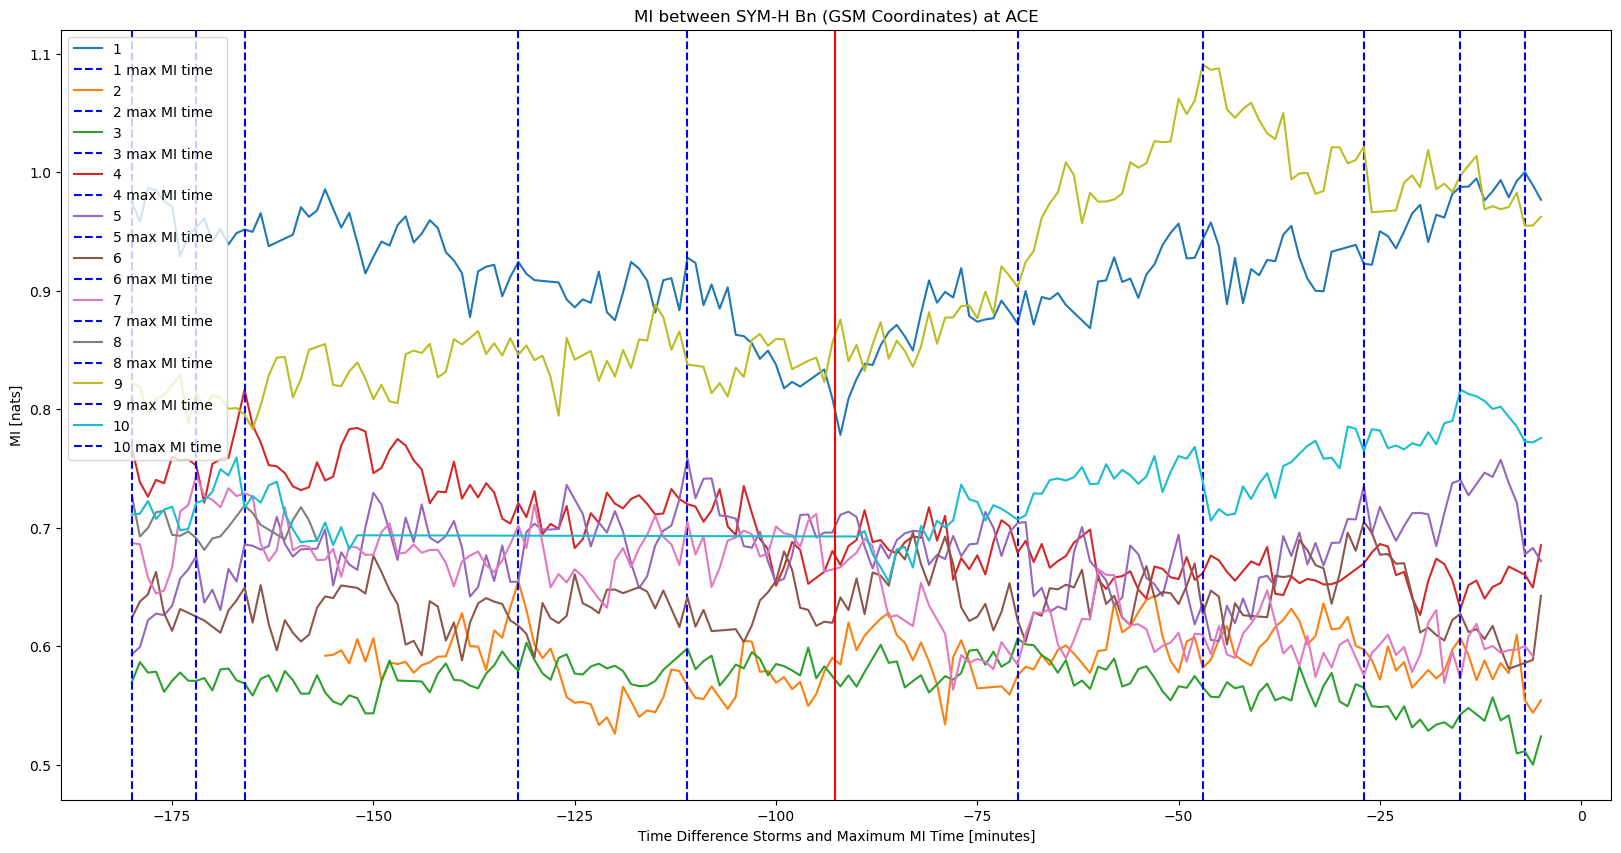

In [422]:
plt.figure(figsize=[20, 10])

for i, storm in enumerate(storm_data):
    try:
        if not analysed1[i]:
            continue
        offset = i - sum(analysed1[:i])
        # print((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60)
        plt.plot((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60, all_storm_MI_matrices1[i - offset][:, -3, 2], label = f"{i - offset + 1}")
        plt.axvline(max_MI_times1[i - offset].total_seconds()/60, color='b', label = f"{i - offset + 1} max MI time", linestyle='--')
    except:
        pass
plt.axvline(average_max_MI_time1.total_seconds()/60, color='r')
plt.title('MI between SYM-H Bn (GSM Coordinates) at ACE')
plt.xlabel('Time Difference Storms and Maximum MI Time [minutes]')
plt.legend()
plt.ylabel('MI [nats]')

In [ ]:
plt.figure(figsize=[20, 10])

for i, storm in enumerate(storm_data):
    try:
        if not analysed2[i]:
            continue
        offset = i - sum(analysed2[:i])
        # print((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60)
        plt.plot((pd.Series(all_matrix_times2[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60, all_storm_MI_matrices2[i - offset][:, -3, 2], label = f"{i - offset + 1}")
        plt.axvline(max_MI_times2[i - offset].total_seconds()/60, color='b', label = f"{i - offset + 1} max MI time", linestyle='--')
    except:
        pass
plt.axvline(average_max_MI_time2.total_seconds()/60, color='r')
plt.title('MI between SYM-H Bn (GSM Coordinates) at ACE')
plt.xlabel('Time Difference Storms and Maximum MI Time [minutes]')
plt.legend()
plt.ylabel('MI [nats]')